# Algorithmes de streaming, BJKST

Les streams (flux) de données sont aujourd'hui présents dans de nombreux domaines (réseaux sociaux, e-commerce, logs de connexion Internet, etc.). L'analyse rapide et pertinente de ces flux est motivée par l'immensité des données qui ne peuvent souvent pas être stockés (du moins facilement) et dont le traitement serait trop lourd (penser au calcul de l'âge moyen des 1,86 milliards utilisateurs de Facebook pour s'en convaincre). Ce notebook s'intéresse particulièrement à l'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts).

In [63]:
%matplotlib inline

## Introduction

Plus formellement considérons un univers $U$ de taille $n$ (un nombre très grand) qui ne peut être stocké en mémoire et une séquence $S = (s_1, s_2, \ldots, s_m, \ldots)$ d'éléments de $U$. Un algorithme de streaming $\mathcal{A}$ prend le stream $S$ en entrée et renvoie une fonction $f(S)$ (souvent à valeurs réelles).

Notons que l'algorithme $\mathcal{A}$ est souvent contraint d'accéder séquentiellement aux éléments de $S$ et / ou ne peut les parcourir qu'un nombre fini de fois.

Un bon algorithme de streaming doit satisfaire plusieurs contraintes:

- Il doit être un bon estimateur de la vraie valeur que prendrait $f^*(U)$ sur l'univers (plus de détails dans un instant)
- Il doit pouvoir s'actualiser rapidement (en temps linéaire ou moins) à mesure que le flux $S$ évolue
- Il doit être peu gourmand en mémoire

Etant donné une précision $\epsilon > 0$ et une tolérance $\delta > 0$, l'algorithme $\mathcal{A}$ doît satisfaire:

$\mathbb{P}(\lvert \frac{f^*(U) - f(S)}{f(S)} \rvert \leq \epsilon) \geq 1 - \delta.$

Quelques exemples fréquents d'algorithmes de streaming:

- Estimation de la valeur moyenne, de la médiane
- Estimation du nombre d'éléments distincts
- Estimation de la fréquences des élements
- Estimation de la densité de probabilité

## Estimer le nombre d'éléments distincts: l'algorithme BJKST

L'algorithme [BJKST](https://pdfs.semanticscholar.org/e349/7952347101a3535434bc35d378224cf87bcc.pdf) permet d'estimer le nombre d'éléments distincts d'un stream $S$. Son fonctionnement est assez simple et repose sur la notion d'universal hashing que nous présentons ci-bas.

### Universal hashing

L'idée derrière les fonctions de hachage est de faire correspondre des élements d'un ensemble dont la taille est variable (ou bien n'est pas connue) vers un ensemble de taille fixe. Le principe de l'universal hashing est de sélectionner aléatoirement une fonction $h$ dans une famille de fonctions de hachage $\mathcal{H}$ et de garantir un faible probabilité du nombre de collisions de hachage. 

Formellement si l'on note $[n]$ l'ensemble $\{1, \ldots, n\}$, une famille de fonctions $\mathcal{H}$ est dite <i>universelle</i> si toute fonction $h: U \mapsto [n]$ choisie uniformément dans la famille $\mathcal{H}$ vérifie $\mathbb{P}(h(x) = h(y)) \leq \frac{1}{n}$ pour tout couple $x,y \in U$ distincts.

Nous considérons ici la famille $\mathcal{H} = \{h_{a,b}\}$ où $h_{a,b}(x) = ((ax + b) \space{} \mathrm{mod} \space{} p) \space{} \mathrm{mod} \space{} n$, $x$ est un entier, $a \in \{1, \ldots, p - 1\}$, $b \in \{0, \ldots, p - 1 \}$ et $p$ un nombre premier $\geq n$. On peut sans trop de difficulté se convaincre que $h_{a,b}(x)$ est uniformément distribué sur $[n]$ et que cette famille est universelle (voir [Universal hashing](https://en.wikipedia.org/wiki/Universal_hashing) pour plus de détails).

### Collisions

Vérifions numériquement le nombre de collisions. Considérons un univers $U$ large prenons par exemple $U = [n]$ avec $n$ grand.

In [64]:
n = 10**4
U = list(range(n))

Choisissons $p$ un nombre premier arbitrairement grand et une petite valeur de hashage.

In [65]:
p = 4294967291
m = 10

Choisissons une fonction $h$ uniformément dans la famille $\mathcal{H}$

In [66]:
import random

a = random.randint(1, p)
b = random.randint(0, p)


def h(x):
    return ((a * x + b) % p) % m

Tirons des couples $(x,y)$ distincts dans $U$

In [67]:
couples = set()
for i in range(500):
    x, y = random.sample(U, 2)
    couples.add((x, y))
print("Nombre de couples distincts = {}".format(len(couples)))

Nombre de couples distincts = 500


Pour chaque couple, calculons les valeurs de hashage et comptons le nombre de collisions.

In [68]:
c = 0
for (
    x,
    y,
) in couples:
    if h(x) == h(y):
        c += 1

Le nombre de collisions rapporté au nombre de couples $(x,y)$ distincts nous donne une estimation de la probabilité de collision.

In [69]:
p_collisions = c / len(couples)
print("Probabilité de collision = {:.2f}%".format(p_collisions * 100.0))

Probabilité de collision = 11.40%


Cette valeur est proche de la valeur théorique $\frac{1}{m}$. Effectuons plusieurs tirages pour confirmer ce résultat.

In [70]:
import numpy

collisions = []
# on reitere 100 fois
for _ in range(100):
    a = random.randint(1, p)
    b = random.randint(0, p)

    def h(x):
        return ((a * x + b) % p) % m

    couples = set()
    for i in range(500):
        x, y = random.sample(U, 2)
        couples.add((x, y))

    c = 0
    for (
        x,
        y,
    ) in couples:
        if h(x) == h(y):
            c += 1
    collisions.append(c / len(couples))
p_collision = numpy.mean(collisions)
print("Probabilité de collision moyenne = {:.2f}%".format(p_collision * 100.0))

Probabilité de collision moyenne = 9.97%


Cette probabilité moyenne est proche de la valeur théorique. Réitérons pour d'autres valeurs $m$.

In [71]:
sizes = [10, 25, 50, 100, 250, 500, 750, 1000]
p_collision = []
p = 4294967291

for m in sizes:
    collisions = []
    # on reitere 100 fois
    for _ in range(100):
        a = random.randint(1, p)
        b = random.randint(0, p)

        def h(x):
            return ((a * x + b) % p) % m

        couples = set()
        for i in range(500):
            x, y = random.sample(U, 2)
            couples.add((x, y))

        c = 0
        for (
            x,
            y,
        ) in couples:
            if h(x) == h(y):
                c += 1
        collisions.append(c / len(couples))
    p_collision.append(numpy.mean(collisions))

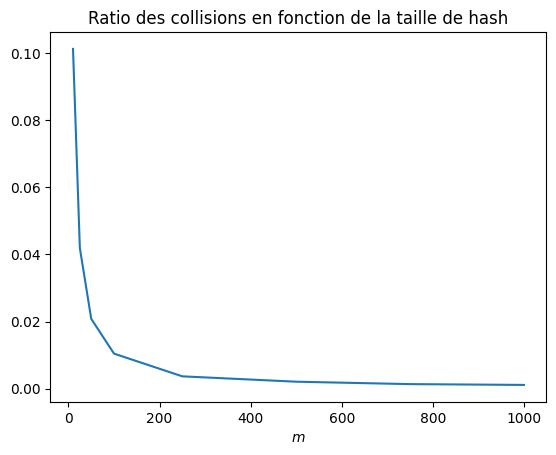

In [72]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots()
plt.plot(sizes, p_collision)
plt.xlabel(r"$m$")
ax.set_title("Ratio des collisions en fonction de la taille de hash");

La probabilité de collision estimée est bien inversement proportionnelle à la valeur de hashage $m$.

### Algorithme BJKST

Nous considérons un univers $U$ de taille $N$ et comportant $n$ élements distincts. Pour un stream $S = (a_1, a_2, \ldots)$ de taille  $s$ essayons d'estimer $n$ à l'aide de l'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts).

In [73]:
n = 10**3
N = 10**4
# nous tirons N entiers de 64bits (type i8) dont n sont distincts
universe = numpy.random.randint(0, n, N, dtype="i8")
s = 500
stream = universe[-s:]

L'idée derrière l'algorithme [BJKST](http://info.prelert.com/blog/hashing-and-approximate-distinct-value-counts) est de parcourir les élements du stream et de remplir un ensemble $B$ par échantillonage. La probabilité d'échantillonage initiale est $1$ et lorsque $B$ devient trop grand (au delà d'un certain seuil $B_{max}$) on enlève des élements et on diminue la probabilité d'échantillonage. A la fin le nombre d'éléments dans $B$ et la probabilité d'échantillonage finale permettent d'estimer le nombre d'éléments distincts dans $U$.

Pour $\epsilon >0$ nous prenons $B_{max} = 1/ \epsilon^2$ :

In [74]:
# definissons un ensemble B
B = set()
epsilon = 0.1
B_max = 1 / epsilon**2

Choisissons $p$ un nombre premier arbitrairement grand:

In [75]:
p = 4294967291

et tirons aléatoirement deux fonctions $h_{a_1, b_1}$ et $h_{a_2, b_2}$ distinctes:

In [76]:
import random

# deux couples (a_1, b_1) (a_1, b_2) distincts
a1, a2 = random.sample(range(1, p), 2)
b1, b2 = random.sample(range(0, p), 2)


def h1(x):
    return ((a1 * x + b1) % p) % s


def h2(x):
    return ((a2 * x + b2) % p) % s

Initialisons un entier $c$ à zero. Pour chaque $x$ dans le stream nous calculons d'abord sa valeur de hachage $y = h_{a_1, b_1}(x)$ :

In [77]:
c = 0
# Prenons le premier élément du stream (à titre d'exemple)
x = stream[0]
y = h1(x)
print("x = {}, y = {}".format(x, y))

x = 464, y = 13


La probabilité d'échantillonage est basée sur le nombre de zéros à droite dans la décomposition binaire de $y$. Pour calculer ce nombre diverses méthodes existent (voir [Count the consecutive zero bits (trailing) on the right with modulus division and lookup ](http://graphics.stanford.edu/~seander/bithacks.html#ZerosOnRightModLookup) pour plus de détails). Pour $s= 2^1$ et $s = 2^{10}$ la décomposition binaire comporte $1$ et $10$ zéros à droite respectivement:

In [78]:
mod_37bit_position = (
    32,
    0,
    1,
    26,
    2,
    23,
    27,
    0,
    3,
    16,
    24,
    30,
    28,
    11,
    0,
    13,
    4,
    7,
    17,
    0,
    25,
    22,
    31,
    15,
    29,
    10,
    12,
    6,
    0,
    21,
    14,
    9,
    5,
    20,
    8,
    19,
    18,
)

# Un seul zéro à droite
s = 2**1
zeros = mod_37bit_position[(-s & s) % 37]
print(
    "Decomposition binaire de 2**1 = {}, nombre de zeros a droite = {}".format(
        bin(s), zeros
    )
)

# Dix zéros à droite
s = 2**10
zeros = mod_37bit_position[(-s & s) % 37]
print(
    "Decomposition binaire de 2**10 = {}, nombre de zeros a droite = {}".format(
        bin(s), zeros
    )
)

Decomposition binaire de 2**1 = 0b10, nombre de zeros a droite = 1
Decomposition binaire de 2**10 = 0b10000000000, nombre de zeros a droite = 10


Notons $k$ le nombre de zéros à droite dans la décomposition binaire de $y$.

In [79]:
k = mod_37bit_position[(-y & y) % 37]
print(
    "Decomposition binaire de y = {}, nombre de zeros a droite = {}".format(bin(y), k)
)

Decomposition binaire de y = 0b1101, nombre de zeros a droite = 0


Puis nous comparons $k \geq c$. Si c'est le cas nous calculons une nouvelle valeur de hashage de $x$, $z = h_{a_2, b_2}(x)$ et rajoutons le couple $(z, k)$ à l'ensemble $B$.

In [80]:
if k >= c:
    z = h2(x)
    B.add((z, k))

A l'initialisation la condition $k \geq c$ est toujours vérifiée (ce qui correspond à une probabilité d'échantillonage égale à $1$) :

In [81]:
B

{(539, 0)}

L'ensemble $B$ se remplit jusqu'à atteindre la taille $B_{max}$. Lorsque cette taille est atteinte on incrémente $c$ et on enlève à $B$ tous les couples $(z, k)$ où $k < c$.

In [82]:
while len(B) >= B_max:
    c += 1
    # on prend ici une copie de B
    for z, k in B.copy():
        if k < c:
            B.remove((z, k))

Parcourons le stream et regardons à quoi ressemble l'ensemble $B$:

In [83]:
for x in stream:
    y = h1(x)
    k = mod_37bit_position[(-y & y) % 37]
    if k >= c:
        z = h2(x)
        B.add((z, k))
        while len(B) >= B_max:
            c += 1
            for z, k in B.copy():
                if k < c:
                    B.remove((z, k))

In [84]:
print("Taille de B = {}, c = {}".format(len(B), c))

Taille de B = 96, c = 2


Une estimateur de la taille de l'univers est alors $2^c \mathrm{card}(B)$ :

In [85]:
print("Estimation de la taille de U = {}".format(2**c * len(B)))

Estimation de la taille de U = 384


Pour s'en convaincre, remarquons qu'en moyenne le cardinal de $B$ est égal au nombre de $y_i$ pour lequel le nombre de zéros à droite dans la décomposition binaire est plus grand que $c$. Ceci correspond au nombre de $y_i$ qui sont divisibles par $2^c$ :

$$\mathbb{E}[\mathrm{card}(B)] = \mathbb{E}\big[\sum_{x_i} I(y_i = 0 \space{} \mathrm{mod} \space{} 2^c)\big] = \sum_{x_i} \mathbb{P}\big( y_i = 0 \space{} \mathrm{mod} \space{} 2^c\big)$$

C'est ici qu'intervient la notion de famille universelle car cette derniere égalité n'est valide que si le nombre de collision entre $y$ et $z$ est faible lors du hachage de $x$ par $h_{a_1, b_1}$ et $h_{a_2, b_2}$. En effet, si le nombre de collisions était trop grand la taille de $B$ sous-estimerait le nombre d'éléments distincts.

La probabilité $\mathbb{P}\big( y_i = 0 \space{} \mathrm{mod} \space{} 2^c\big)$ étant égale à $1 / 2^c$ si $y_i$ est distribué uniformément (l'écrire pour s'en convaincre) nous obtenons :

$$ \mathbb{E}[\mathrm{card}(B)] = \frac{n}{2^c}.$$

### Résultats numériques

Regroupons le code dans une fonction

In [86]:
def BJKST(stream, epsilon):
    s = len(stream)
    a1, a2 = random.sample(range(1, p), 2)
    b1, b2 = random.sample(range(0, p), 2)

    def h1(x):
        return ((a1 * x + b1) % p) % s

    def h2(x):
        return ((a2 * x + b2) % p) % s

    c = 0
    B = set()
    B_max = 1.0 / epsilon**2
    for x in stream:
        y = h1(x)
        k = mod_37bit_position[(-y & y) % 37]
        if k >= c:
            z = h2(x)
            B.add((z, k))
            while len(B) >= B_max:
                c += 1
                for z, k in B.copy():
                    if k < c:
                        B.remove((z, k))
    return 2**c * len(B)

En pratique une estimation fiable du nombre d'éléments distincts requiert de générer plusieurs calculs indépendants de l'algorithme et de prendre la médiane. Regardons comment la qualité de l'estimation évolue en fonction de la précision $\epsilon$ exigée et de la taille $s$ du stream.

In [87]:
epsilons = [0.5, 0.2, 0.1]
sizes = [100, 250, 500, 1000, 2500, 5000]
estimates = {}
for eps in epsilons:
    values = []
    for s in sizes:
        stream = universe[-s:]
        values.append(numpy.median([BJKST(stream, eps) for _ in range(100)]))
    estimates[eps] = values

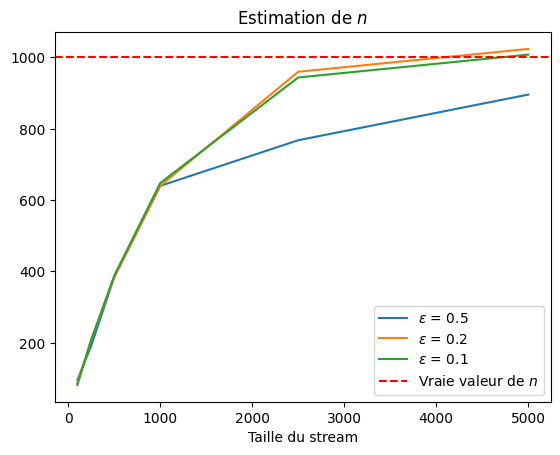

In [88]:
for eps in estimates:
    plt.plot(sizes, estimates[eps], label="$\epsilon$ = {:.1f}".format(eps))
plt.axhline(y=n, color="r", linestyle="--", label="Vraie valeur de $n$")
plt.title("Estimation de $n$")
plt.xlabel("Taille du stream")
plt.legend()

In [89]:
epsilon = 0.1
for i in range(len(sizes)):
    print(
        "Erreur relative = {0:.2f}%, s = {1}".format(
            abs(estimates[epsilon][i] / n - 1.0) * 100.0, sizes[i]
        )
    )

Erreur relative = 91.80%, s = 100
Erreur relative = 79.20%, s = 250
Erreur relative = 61.20%, s = 500
Erreur relative = 35.20%, s = 1000
Erreur relative = 5.60%, s = 2500
Erreur relative = 0.80%, s = 5000


Nous observons que l'estimation converge vers la vraie valeur $n$ à mesure que la taille du stream augmente. Pour une précision $\epsilon = 10\%$ et une taille de stream égale à $5000$ l'erreur est de $0,8\%$.

La fiabilité de l'estimation est décroissante avec le niveau de précision exigé, l'algorithme donne une bonne estimation de la vraie valeur (ligne horizontale rouge) pour $\epsilon \approx 0.3$.

### Temps de calcul en fonction de la taille du stream

Regardons à présent comment le temps de calcul évolue en fonction de la taille du stream. Rappelons qu'un bon algorithme de streaming doit évoluer de manière au pire linéaire en fonction de la taille d'espace $s$.

In [90]:
import time

epsilon = 0.1
size_bound = 15
sizes = [100, 250, 500, 1000, 2500, 5000]
m = 100
times = []
for s in sizes:
    start = time.time()
    stream = universe[-s:]
    BJKST(stream, epsilon)
    times.append(time.time() - start)
times = numpy.array(times)

Text(0.5, 0, 'Taille du stream')

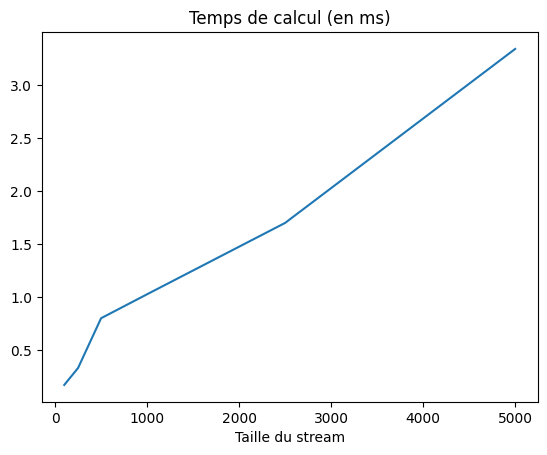

In [91]:
fix, ax = plt.subplots()
plt.plot(sizes, times * 1000)
plt.title("Temps de calcul (en ms)")
plt.xlabel("Taille du stream")

La complexité semble être linéaire ce qui est satisfaisant. Notons qu'aucun effort d'optimisation de performance (à part l'usage d'un <b>set</b>) n'a été fait à ce stade.

## Un peu plus sur la précision de l'estimateur

Lorsque la précision $\epsilon$ est proche de $0$ l'estimation est moins bonne que pour une précision plus large. Pourquoi ?

In [92]:
import random
import numpy
import matplotlib.pyplot as plt

%matplotlib inline

n = 1000
stream = numpy.arange(1000)
p = 4294967291

mod_37bit_position = (
    32,
    0,
    1,
    26,
    2,
    23,
    27,
    0,
    3,
    16,
    24,
    30,
    28,
    11,
    0,
    13,
    4,
    7,
    17,
    0,
    25,
    22,
    31,
    15,
    29,
    10,
    12,
    6,
    0,
    21,
    14,
    9,
    5,
    20,
    8,
    19,
    18,
)

In [93]:
def BJKST(stream, B_max, h1, h2):
    c = 0
    B = set()
    R = []
    removed = 0
    for x in stream:
        y = h1(x)
        k = mod_37bit_position[(-y & y) % 37]
        if k >= c:
            z = h2(x)
            B.add((z, k))
            while len(B) >= B_max:
                c += 1
                for z, k in B.copy():
                    if k < c:
                        B.remove((z, k))
                        removed += 1
        R.append([removed, len(B), c])
    return numpy.array(R)

### $h_1$ et $h_2$ égales à l'identité

Si nous prenons $h_1$ et $h_2$ égales à l'identité l'ensemble $B$ se remplit linéairement: pour $c=1$ on enlève tous les nombres avec $k = 0$ (tous les nombres impairs donc la moitié) puis pour $c=2$ on enlève tous les nombres où $k = 0, 1$ c'est à dire encore la moitié des nombres rajoutés et ainsi de suite.. 

A la fin l'estimation est parfaite (cf graphe en fonction de l'avancement dans le stream)

Estimated = 1000, true = 1000, c= 3


Text(0, 0.5, 'size')

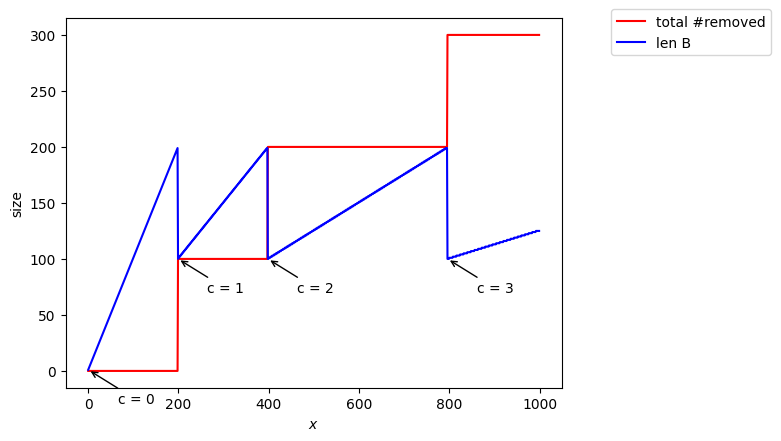

In [94]:
B_max = 200


def h1(x):
    return x


def h2(x):
    return x


R = BJKST(stream, B_max, h1, h2)
estimate = 2 ** R[-1, 2] * R[-1, 1]
print("Estimated = {}, true = {}, c= {}".format(estimate, n, R[-1, 2]))
D = numpy.concatenate((numpy.array([1]), numpy.diff(R[:, 2])))
changes = stream[numpy.nonzero(D)]

fix, ax = plt.subplots()
ax.plot(stream, R[:, 0], color="red", label="total #removed")
ax.plot(stream, R[:, 1], color="blue", label="len B")
for c in changes:
    ax.annotate(
        "c = {}".format(R[c, 2]),
        xy=(c, R[c, 1]),
        xytext=(c + 65, R[c, 1] - 30),
        arrowprops=dict(arrowstyle="->"),
    )
ax.legend(loc=(1.1, 0.9))
plt.xlabel("$x$")
plt.ylabel("size")

### cas où la taille du hash est petite

Si on prend un hash petit il faut regarder plus de nombres pour remplir et l'incrément de $c$ se fait "plus tard" dans le stream, d'où la mauvaise estimation.

Estimated = 616, true = 1000, c= 2


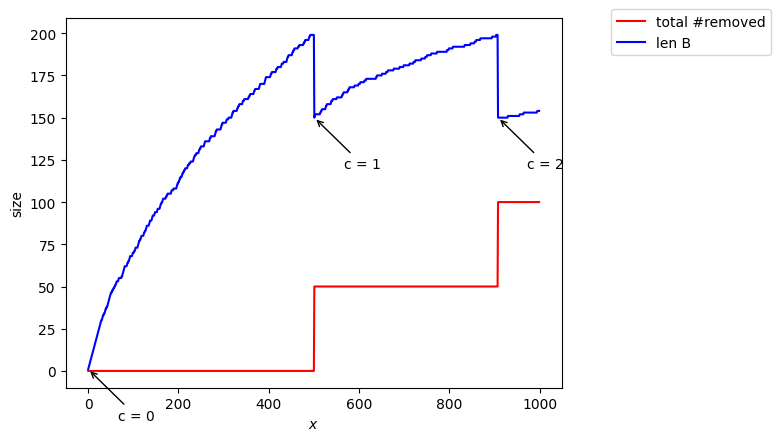

In [95]:
B_max = 200
s = B_max // 4
a1, a2 = random.sample(range(1, p), 2)
b1, b2 = random.sample(range(0, p), 2)


def h1(x):
    return ((a1 * x + b1) % p) % n


def h2(x):
    return ((a2 * x + b2) % p) % s


R = BJKST(stream, B_max, h1, h2)
estimate = 2 ** R[-1, 2] * R[-1, 1]
print("Estimated = {}, true = {}, c= {}".format(estimate, n, R[-1, 2]))
D = numpy.concatenate((numpy.array([1]), numpy.diff(R[:, 2])))
changes = stream[numpy.nonzero(D)]
fix, ax = plt.subplots()
ax.plot(stream, R[:, 0], color="red", label="total #removed")
ax.plot(stream, R[:, 1], color="blue", label="len B")
for c in changes:
    ax.annotate(
        "c = {}".format(R[c, 2]),
        xy=(c, R[c, 1]),
        xytext=(c + 65, R[c, 1] - 30),
        arrowprops=dict(arrowstyle="->"),
    )
ax.legend(loc=(1.1, 0.9))
plt.xlabel("$x$")
plt.ylabel("size");

### cas où la taille de hash est plus grande

Si on prend un une valeur de hash plus grande on se rapproche du cas $h_1 = h_2 = id$ et l'estimation est meilleure :

Estimated = 984, true = 1000, c= 3


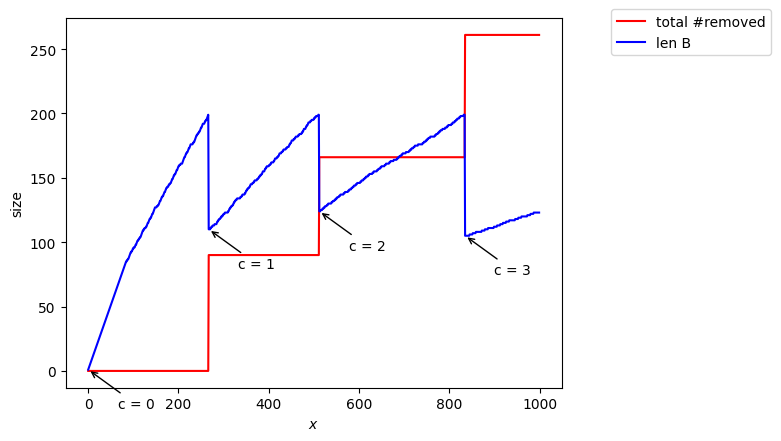

In [96]:
B_max = 200
s = B_max
a1, a2 = random.sample(range(1, p), 2)
b1, b2 = random.sample(range(0, p), 2)


def h1(x):
    return ((a1 * x + b1) % p) % n


def h2(x):
    return ((a2 * x + b2) % p) % s


R = BJKST(stream, B_max, h1, h2)
estimate = 2 ** R[-1, 2] * R[-1, 1]
print("Estimated = {}, true = {}, c= {}".format(estimate, n, R[-1, 2]))
D = numpy.concatenate((numpy.array([1]), numpy.diff(R[:, 2])))
changes = stream[numpy.nonzero(D)]
fix, ax = plt.subplots()
ax.plot(stream, R[:, 0], color="red", label="total #removed")
ax.plot(stream, R[:, 1], color="blue", label="len B")
for c in changes:
    ax.annotate(
        "c = {}".format(R[c, 2]),
        xy=(c, R[c, 1]),
        xytext=(c + 65, R[c, 1] - 30),
        arrowprops=dict(arrowstyle="->"),
    )
ax.legend(loc=(1.1, 0.9))
plt.xlabel("$x$")
plt.ylabel("size");

### la taille de hash dépend de la précision $\epsilon$

A mon avis, il faut donc que la taille du hash pour $h_2$ dépende de la précision (dans [Data Stream Algorithms](http://www.cs.dartmouth.edu/~ac/Teach/CS85-Fall09/Notes/lecnotes.pdf) ils préconisent une taille en $\mathrm{log}(n) / \epsilon^2$).

Si on prend cette taille pour $h_2$ on voit que l'estimation est meilleure pour une précision petite.

In [97]:
def BJKST(stream, epsilon):
    a1, a2 = random.sample(range(1, p), 2)
    b1, b2 = random.sample(range(0, p), 2)
    # taille de la valeur de hashage dépend de la precision
    b = int(numpy.log(n) / epsilon**2)

    def h1(x):
        return ((a1 * x + b1) % p) % n

    # on applique la taille b sur la seconde fonction de hash
    def h2(x):
        return ((a2 * x + b2) % p) % b

    c = 0
    B = set()
    B_max = 1.0 / epsilon**2
    for x in stream:
        y = h1(x)
        k = mod_37bit_position[(-y & y) % 37]
        if k >= c:
            z = h2(x)
            B.add((z, k))
            while len(B) >= B_max:
                c += 1
                for z, k in B.copy():
                    if k < c:
                        B.remove((z, k))
    return 2**c * len(B)

In [98]:
m = 100
epsilons = numpy.array([0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01])
medians = numpy.array(
    [numpy.median([BJKST(stream, eps) for _ in range(m)]) for eps in epsilons]
)

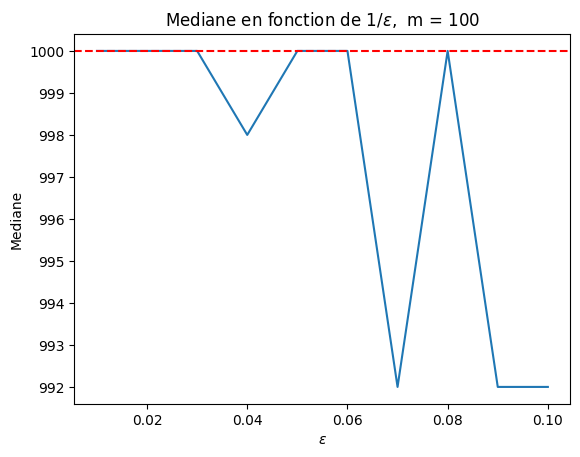

In [99]:
import matplotlib.pyplot as plt

%matplotlib inline

# plt.plot(1.0 / epsilons, medians)
plt.plot(epsilons, medians)
plt.axhline(y=n, color="r", linestyle="--")
plt.title(r"Mediane en fonction de $1 / \epsilon$,  m = {}".format(m))
plt.xlabel(r"$\epsilon$")
plt.ylabel("Mediane");